In [1]:

import matplotlib.pyplot as plt
import numpy as np

from pydicom import dcmread
import cv2
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import natsort
import json
import h5py
import pandas as pd
import nibabel as nib
from dtd import autopatch
import pprint as pp
import plotly.graph_objects as go
import os
%matplotlib widget

# LV_APEX_ENDO:  215 133
# LV_APEX_EPI:  217 109

In [28]:
def get_pixel_coordinates(dcm_file):
    
    img = dcm_file.pixel_array
    img_dim = img.shape 
    ipp = dcm_file.ImagePositionPatient # upper left-hand corner of the image. (x,y,z)
    iop = dcm_file.ImageOrientationPatient

    X_iop = np.asarray(iop[:3], dtype=float)
    Y_iop = np.asarray(iop[3:], dtype=float)
    ps = dcm_file.PixelSpacing 

    A = np.array([[X_iop[0]*ps[0], Y_iop[0]*ps[1], 0, ipp[0]],
                  [X_iop[1]*ps[0], Y_iop[1]*ps[1], 0, ipp[1]],
                  [X_iop[2]*ps[0], Y_iop[2]*ps[1], 0, ipp[2]]]) # transformation matrix that maps pixel coordinates to physical coordinates.
    
    P_out = np.zeros((img_dim[0], img_dim[1], 4))
    for i in range(img_dim[1]): 
        for j in range(img_dim[0]):
            B = [[i],[j],[0],[1]]
            P_out[j,i,:] = np.vstack((np.matmul(A, B), img[j,i])).T
    return P_out

def get_3d_coordinates(dcm_file, i, j):
    ipp = dcm_file.ImagePositionPatient
    iop = dcm_file.ImageOrientationPatient
    ps = dcm_file.PixelSpacing

    X_iop = np.asarray(iop[:3], dtype=float)
    Y_iop = np.asarray(iop[3:], dtype=float)
    
    A = np.array([[X_iop[0]*ps[0], Y_iop[0]*ps[1], 0, ipp[0]],
                  [X_iop[1]*ps[0], Y_iop[1]*ps[1], 0, ipp[1]],
                  [X_iop[2]*ps[0], Y_iop[2]*ps[1], 0, ipp[2]]])

    B = np.array([[i], [j], [0], [1]])
    physical_coords = np.matmul(A, B)
    
    return physical_coords[:3].flatten()

def load_lax(dcm_folder, target_frame_num):
    files = natsort.natsorted([f.name for f in dcm_folder.iterdir()])

    frame_int = target_frame_num
    file_list_lax = [files[frame_int]]
    return file_list_lax
    


In [29]:

subject_id = 21
dcm_folder_sax = Path(Path(Path.home(), f"/Users/giuliamonopoli/Desktop/PhD /Data/ES_files/{subject_id}/DICOM_files") )
img_paths = [f for f in os.listdir(dcm_folder_sax) if f!= ".dcm"]
dcm_folder_lax = Path(Path.home(), f"/Users/giuliamonopoli/Desktop/PhD /Data/MAD_OUS_sorted/{subject_id}/cine/4ch/")
target_frame_num = 18 # ES frame number

file_list_sax =  sorted(img_paths, key=lambda x: int(os.path.basename(x).split('sliceloc_')[1].split('.')[0]))
file_list_lax = load_lax(dcm_folder_lax, target_frame_num)

dcm_sax = [dcmread(dcm_folder_sax.joinpath(Path(f))) for f in file_list_sax]
dcm_lax = [dcmread(dcm_folder_lax.joinpath(Path(f))) for f in file_list_lax]

In [30]:
" Get MV insertion points from DeepValve annotations"

from dataclasses import dataclass, field, InitVar
from typing import List, Dict
@dataclass
class Annotation:
    mv_insert_septal: List[List[int]]
    mv_insert_lateral: List[List[int]]
    lv_base_septal: List[List[int]]
    lv_base_lateral: List[List[int]]
    leaflet_septal: List[List[int]]
    leaflet_lateral: List[List[int]]
@dataclass
class PatientData:
    patient_name: str
    key_frames: List[str]
    annotations: Dict[str, Annotation]
    bounding_box: List[int]
    flags: InitVar[List[int]] = None
    
def get_patient_data_list(patient_names: List[str], data_list: List[PatientData]) -> List[PatientData]:
    return [patient_data for patient_data in data_list if patient_data.patient_name in patient_names]


with open("/Users/giuliamonopoli/Desktop/PhD /deepvalve/data/new_annotations", "r") as json_file:
        data = json.load(json_file)
    
patient_data = [PatientData(**data[i]) for i, _ in enumerate(data)]
def get_patient_data(patient_name, patients_list):
    for patient in patients_list:
        if patient.patient_name == patient_name:
            return patient
    return None  



specific_patient_data = get_patient_data(f"MAD_{subject_id}_0", patient_data)
sd = specific_patient_data.annotations
mv_insert_septal = np.array(sd[f"{target_frame_num}"]["mv_insert_septal"])
mv_insert_lateral = np.array(sd[f"{target_frame_num}"]["mv_insert_lateral"])
n_max_sax = len(dcm_sax)
choose_sax = np.arange(0, n_max_sax)

########### Transform LAX pixel coordinates to physical coordinates ###########
dcm_file = dcm_lax[0]
P = get_pixel_coordinates(dcm_file)
px = dcm_file.PixelSpacing

########### Transform MV insertion points  to physical coordinates ###########
i, j =  int(np.array(mv_insert_lateral[0][1])//2) , int(np.array(mv_insert_lateral[0][2])//2) 
i2, j2 = int(np.array(mv_insert_septal[0][1])//2) , int(np.array(mv_insert_septal[0][2])//2)

physical_coords = get_3d_coordinates(dcm_file, i, j)
physical_coords2 = get_3d_coordinates(dcm_file, i2, j2)

LV_APEX_ENDO = 215, 133
LV_APEX_EPI=  217, 109
phy_a_endo = get_3d_coordinates(dcm_file, LV_APEX_ENDO[0], LV_APEX_ENDO[1])
phy_a_epi = get_3d_coordinates(dcm_file, LV_APEX_EPI[0], LV_APEX_EPI[1])

In [31]:
subject_id = 21
segmentation_file = f"/Users/giuliamonopoli/Desktop/PhD /Data/ES_files/{subject_id}/NIfTI_files/{subject_id}.nii"
seg_data = nib.load(segmentation_file).get_fdata()
rv_mask = np.uint8(seg_data == 3)
rv_mask = np.squeeze(rv_mask)
rv_mask =  np.transpose(rv_mask, (1, 0, 2))

dcm_folder_sax = Path(Path(Path.home(), f"/Users/giuliamonopoli/Desktop/PhD /Data/ES_files/{subject_id}/DICOM_files") )
img_paths = [f for f in os.listdir(dcm_folder_sax) if f!= ".dcm"]
# Initialize variables to keep track of the maximum count and index
max_segmented_pixels = 0
max_slice_index = -1

# Loop through each slice in the stack (assuming segmentation along the last axis)
for i in range(rv_mask.shape[-1]):
    segmented_pixels_count = np.count_nonzero(rv_mask[..., i])
    
    if segmented_pixels_count > max_segmented_pixels:
        max_segmented_pixels = segmented_pixels_count
        max_slice_index = i

file_list_sax =  sorted(img_paths, key=lambda x: int(os.path.basename(x).split('sliceloc_')[1].split('.')[0]))
dcm_rv = dcmread(dcm_folder_sax.joinpath(Path(file_list_sax[max_slice_index])))
base = rv_mask[..., max_slice_index]

indices = np.argwhere(base != 0)

# Calculate the mean of the indices to find the center
rv_center = np.mean(indices, axis=0)


rv_center= get_3d_coordinates(dcm_rv, rv_center[1], rv_center[0])
rv_center = np.array([rv_center])

In [ ]:
fig = go.Figure()
dcm_file = dcm_lax[0]
P = get_pixel_coordinates(dcm_file)
X, Y, Z, img = P[:, :, 0], P[:, :, 1], P[:, :, 2], P[:, :, 3]
img = cv2.convertScaleAbs(img, alpha=255 / img.max())

fig.add_surface(x=X, y=Y, z=Z, surfacecolor=img, colorscale="Greys_r", showscale=False, showlegend=True, name="LAX")

for i_sax in range(len(dcm_sax)):
    dcm_file = dcm_sax[i_sax]
    P = get_pixel_coordinates(dcm_file)
    X, Y, Z, img = P[:, :, 0], P[:, :, 1], P[:, :, 2], P[:, :, 3]
    img = cv2.convertScaleAbs(img, alpha=255 / img.max())
    fig.add_surface(x=X, y=Y, z=Z,
                    name=str(f"SAX{i_sax}"),
                    surfacecolor=img,
                    colorscale="Greys_r",
                    showlegend=True,
                    opacity=1.0,
                    showscale=False)
fig.add_trace(go.Scatter3d(x=[rv_center[0]], y=[rv_center[1]], z=[rv_center[2]],
                           mode='markers', marker=dict(size=5, color='red'),
                           name="Mitral Valve Insertion Points"))
fig.layout.scene.camera.projection.type = "orthographic"
slider_sax = {
    
    'active': 100,
    'currentvalue': {'prefix': 'Opacity: '},
    'steps': [{
        'value': step/100,
        'label': f'{step}%',
        'visible': True,
        'execute': True,
        'method': 'restyle',
        'args': [{'opacity': step/100}, [i for i in range(1, n_max_sax+1)]]     # apply to sax only
    } for step in range(101)]
}
fig.update_layout(sliders=[slider_sax])

fig.show()

Value of s where u is perpendicular to d_origin_apex: 0.27947851367386495
Dot product before transformation: -4.263256414560601e-13
Are the vectors orthogonal before transformation? Yes
Dot product after transformation: 3.0449427878989417e-13
Are the vectors orthogonal after transformation? Yes


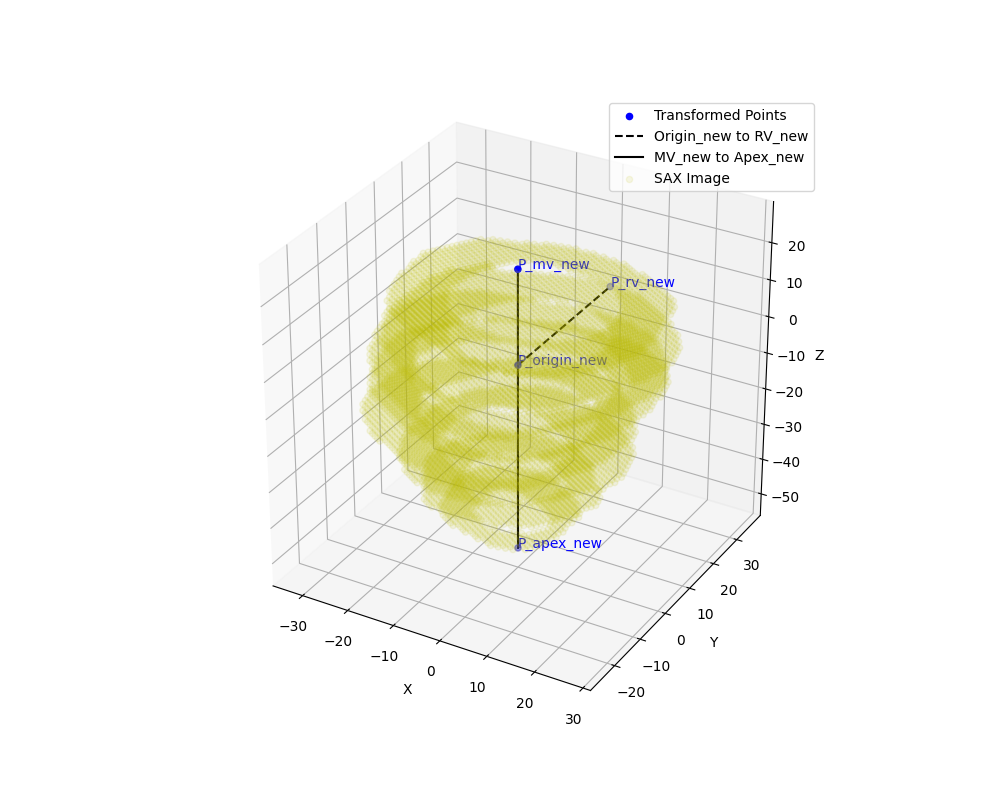

In [36]:
import numpy as np
import matplotlib.pyplot as plt
def transfer_to_new_basis(P, P_origin, P_apex, P_rv_new):
    # Define the orthonormal basis
    e1 = (-P_apex+ P_origin) / np.linalg.norm(-P_apex + P_origin)
    e2 = (P_rv_new - P_origin) / np.linalg.norm(P_rv_new - P_origin)
    e3 = np.cross(e1, e2)
    e3 = e3 / np.linalg.norm(e3)

    assert np.isclose(simple_dot(e1[0], e2[0].T), 0.0)
    assert np.isclose(simple_dot(e1[0], e3[0].T), 0.0)
    assert np.isclose(simple_dot(e2[0], e3[0].T), 0.0)
    

    # Target basis
    Et = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    E0 = np.vstack((e3, e2, e1))
    # print(f"Initial basis vectors:\n{E0}")
    R = Et @ E0.T
   
    # print(f"Rotation matrix:\n{R}")

    # Rotate P using rotation matrix R and translate origin
    P_new = np.zeros((P.shape))
    for i in range(P.shape[0]):
        P_new[i, :] = (P[i, :] - P_origin[0]) @ R

    return P_new,R
def simple_dot(u, v):
    return u[0] * v[0] + u[1] * v[1] + u[2] * v[2]

P1 = np.array(physical_coords)  # Mitral valve insertion point 1 (lateral)
P2 = np.array(physical_coords2)  # Mitral valve insertion point 2 (septal)

P_mv =  np.array([(P1 + P2) / 2])
P_apex = np.array([phy_a_epi])

d_mv_apex = P_apex - P_mv

# Define the location of the origin mid-LV
P_origin = P_mv + (1 / 3) * d_mv_apex
d_origin_apex = P_apex - P_origin

# Define the line from LV to RV
P_rv = rv_center
def find_rv_ortho(P_rv):

    num = (
        -(P_rv[0, 0] - P_origin[0, 0]) * (P_apex[0, 0] - P_origin[0, 0])
        - (P_rv[0, 1] - P_origin[0, 1]) * (P_apex[0, 1] - P_origin[0, 1])
        - (P_rv[0, 2] - P_origin[0, 2]) * (P_apex[0, 2] - P_origin[0, 2])
    )
    den = (
        (P_apex[0, 0] - P_origin[0, 0]) ** 2
        + (P_apex[0, 1] - P_origin[0, 1]) ** 2
        + (P_apex[0, 2] - P_origin[0, 2]) ** 2
    )
    s = num / den
    print(f"Value of s where u is perpendicular to d_origin_apex: {s}")
    return P_rv + s * d_origin_apex

P_rv_new = find_rv_ortho(P_rv)
# num = (
#     -(P_rv[0, 0] - P_origin[0, 0]) * (P_apex[0, 0] - P_origin[0, 0])
#     - (P_rv[0, 1] - P_origin[0, 1]) * (P_apex[0, 1] - P_origin[0, 1])
#     - (P_rv[0, 2] - P_origin[0, 2]) * (P_apex[0, 2] - P_origin[0, 2])
# )
# den = (
#     (P_apex[0, 0] - P_origin[0, 0]) ** 2
#     + (P_apex[0, 1] - P_origin[0, 1]) ** 2
#     + (P_apex[0, 2] - P_origin[0, 2]) ** 2
# )

# s = num / den
# print(f"Value of s where u is perpendicular to d_origin_apex: {s}")
# P_rv_new = P_rv + s * d_origin_apex
# Calculate vectors before transformation
direction_rv = P_rv_new - P_origin
d_origin_apex = P_apex - P_origin

# Check orthogonality before transformation
dot_product_before = np.dot(d_origin_apex[0], direction_rv[0])
print(f"Dot product before transformation: {dot_product_before}")
print(f"Are the vectors orthogonal before transformation? {'Yes' if np.isclose(dot_product_before, 0.0, atol=1e-6) else 'No'}")


P = np.vstack((P_mv, P_apex, P_rv_new, P_origin))
P_new,R = transfer_to_new_basis(P, P_origin, P_apex, P_rv_new)
# Calculate vectors after transformation
P_mv_new = P_new[0]
P_apex_new = P_new[1]
PP = P_new[2]
P_origin_new = P_new[3]

direction_rv_new = PP - P_origin_new
d_origin_apex_new = P_mv_new - P_origin_new

# Check orthogonality after transformation
dot_product_after = np.dot(d_origin_apex_new, direction_rv_new)
print(f"Dot product after transformation: {dot_product_after}")
print(f"Are the vectors orthogonal after transformation? {'Yes' if np.isclose(dot_product_after, 0.0, atol=1e-6) else 'No'}")

def load_mask_coordinates(file_path):
    with h5py.File(file_path, 'r') as f:
        x_mask_coords = f['x_mask_coords'][:]
        y_mask_coords = f['y_mask_coords'][:]
        z_mask_coords = f['z_mask_coords'][:]
    return x_mask_coords, y_mask_coords, z_mask_coords



mask_coords_file_path = f"/Users/giuliamonopoli/Desktop/PhD /Data/ES_files/21/Global_Segmentations/21_global_segmentation_3D.h5"
x_mask_coords, y_mask_coords, z_mask_coords = load_mask_coordinates(mask_coords_file_path)
sax_coords = np.column_stack((x_mask_coords, y_mask_coords, z_mask_coords))
# # Transform coordinates to the new basis
sax_coords_transformed = (sax_coords - P_origin[0]) @ R

# Plot the data
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Plot original points
# ax.scatter(P[:, 0], P[:, 1], P[:, 2], color="r", label="Original Points")
ax.scatter(P_new[:, 0], P_new[:, 1], P_new[:, 2], color="b", label="Transformed Points")
# Label the points
# ax.text(P[0, 0], P[0, 1], P[0, 2], 'P_mv', color='r')
# ax.text(P[1, 0], P[1, 1], P[1, 2], 'P_apex', color='r')
# ax.text(P[2, 0], P[2, 1], P[2, 2], 'P_rv', color='r')
# ax.text(P[3, 0], P[3, 1], P[3, 2], 'P_origin', color='r')


ax.text(P_new[0, 0], P_new[0, 1], P_new[0, 2], 'P_mv_new', color='b')
ax.text(P_new[1, 0], P_new[1, 1], P_new[1, 2], 'P_apex_new', color='b')
ax.text(P_new[2, 0], P_new[2, 1], P_new[2, 2], 'P_rv_new', color='b')
ax.text(P_new[3, 0], P_new[3, 1], P_new[3, 2], 'P_origin_new', color='b')

# Plot lines connecting the points
ax.plot([P_new[3, 0], P_new[2, 0]], [P_new[3, 1], P_new[2, 1]], [P_new[3, 2], P_new[2, 2]], color='k', linestyle='--', label='Origin_new to RV_new')
ax.plot([P_new[0, 0], P_new[1, 0]], [P_new[0, 1], P_new[1, 1]], [P_new[0, 2], P_new[1, 2]], color='k', linestyle='-', label='MV_new to Apex_new')


# Plot the transformed SAX DICOM image
ax.scatter(sax_coords_transformed[:, 0], sax_coords_transformed[:, 1], sax_coords_transformed[:, 2], color='y', alpha=0.1, label='SAX Image')

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
ax.set_box_aspect([1,1,1])  

plt.show()



In [33]:
fig = go.Figure()

# Add original points
fig.add_trace(go.Scatter3d(x=P[:, 0], y=P[:, 1], z=P[:, 2], mode='markers', marker=dict(color='red', size=5), name='Original Points'))

# Add transformed points
fig.add_trace(go.Scatter3d(x=P_new[:, 0], y=P_new[:, 1], z=P_new[:, 2], mode='markers', marker=dict(color='blue', size=5), name='Transformed Points'))

# Add lines connecting the points
fig.add_trace(go.Scatter3d(x=[P_new[3, 0], P_new[2, 0]], y=[P_new[3, 1], P_new[2, 1]], z=[P_new[3, 2], P_new[2, 2]], mode='lines', line=dict(color='black', dash='dash'), name='Origin_new to RV_new'))
fig.add_trace(go.Scatter3d(x=[P_new[0, 0], P_new[1, 0]], y=[P_new[0, 1], P_new[1, 1]], z=[P_new[0, 2], P_new[1, 2]], mode='lines', line=dict(color='black'), name='MV_new to Apex_new'))

# Add transformed SAX DICOM image
fig.add_trace(go.Scatter3d(x=sax_coords_transformed[:, 0], y=sax_coords_transformed[:, 1], z=sax_coords_transformed[:, 2], mode='markers', marker=dict(color='yellow', size=1, opacity=0.1), name='SAX Image'))

# Set labels and title
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'), title='3D Plot of Transformed Coordinates')

# Save the figure as an HTML file
fig.write_html("transformed_coordinates.html")

# Show the figure
fig.show()